In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import numpy.random
os.chdir('/Users/cody/Documents/GitHub/DSCI235-Project/235_Project')

# Non-Goalie (Skater) Data

In [2]:
non_goal = pd.read_csv('Non_goalie_advanced_data.csv')

In [3]:
non_goal.head()

,Player,Age,Tm,GP,CF,CA,CF%,CF% rel,FF,FA,...,TOI(EV),TK,GV,E+/-,SAtt.,Thru%,F,D,C,W
0,Justin Abdelkader,31.0,DET,71,782,918,46.0,-2.8,571,716,...,12:54,9,40,-11.0,159.0,59.7,0,0,0,1
1,Pontus Åberg,25.0,TOT,59,722,681,51.5,3.3,521,525,...,12:31,15,36,-0.3,NaN,NaN,0,0,0,1
2,Pontus Åberg,25.0,ANA,37,511,449,53.2,7.4,360,351,...,13:32,13,31,-0.4,153.0,48.4,0,0,0,1
3,Pontus Åberg,25.0,MIN,22,211,232,47.6,-4.1,161,174,...,10:48,2,5,0.1,58.0,46.6,0,0,0,1
4,Vitaly Abramov,20.0,OTT,1,9,13,40.9,-1.8,4,9,...,13:01,4,2,-0.8,5.0,0.0,0,0,0,1


## Removed Forwards 

Forwards are a general term for each of Centers(C) and Left/Right Wingers(W)

In [4]:
non_goal = non_goal[['Age', 'CF%', 'D', 'C', 'W']]

In [5]:
non_goal.head()

,Age,CF%,D,C,W
0,31.0,46.0,0,0,1
1,25.0,51.5,0,0,1
2,25.0,53.2,0,0,1
3,25.0,47.6,0,0,1
4,20.0,40.9,0,0,1


In [6]:
defender = non_goal[(non_goal['D'] == 1)]
defender = defender.dropna()
defender.head()

,Age,CF%,D,C,W
11,27.0,53.1,1,0,0
12,30.0,51.8,1,0,0
18,22.0,51.4,1,0,0
40,28.0,40.6,1,0,0
42,27.0,53.0,1,0,0


In [7]:
x_d = defender['Age'].values
y_d = defender['CF%'].values
index = np.argsort(x_d)
x_d = x_d[index]
y_d = y_d[index]

In [8]:
lowess = sm.nonparametric.lowess
loess_result = lowess(y_d, x_d, frac=0.5, return_sorted=True)
xd_fit = loess_result[:, 0]
yd_fit = loess_result[:, 1]

n_boot = 100
y_boots = np.full((n_boot, len(xd_fit)), np.nan)

for i in range(n_boot):
    sample_idx = np.random.choice(len(x_d), size=len(x_d), replace=True)
    y_sample = y_d[sample_idx]
    x_sample = x_d[sample_idx]
    
    loess_boot = lowess(y_sample, x_sample, frac=0.5, return_sorted=True)
    y_b = loess_boot[:,1]
    x_b = loess_boot[:,0]

    interp = np.interp(xd_fit, x_b, y_b, left=np.nan, right=np.nan)
    y_boots[i, :] = interp

In [9]:
y_boots.shape

(100, 2242)

In [10]:
std = np.nanstd(y_boots, axis=0)
upper_band = yd_fit + 1.96 * std
lower_band = yd_fit - 1.96 * std

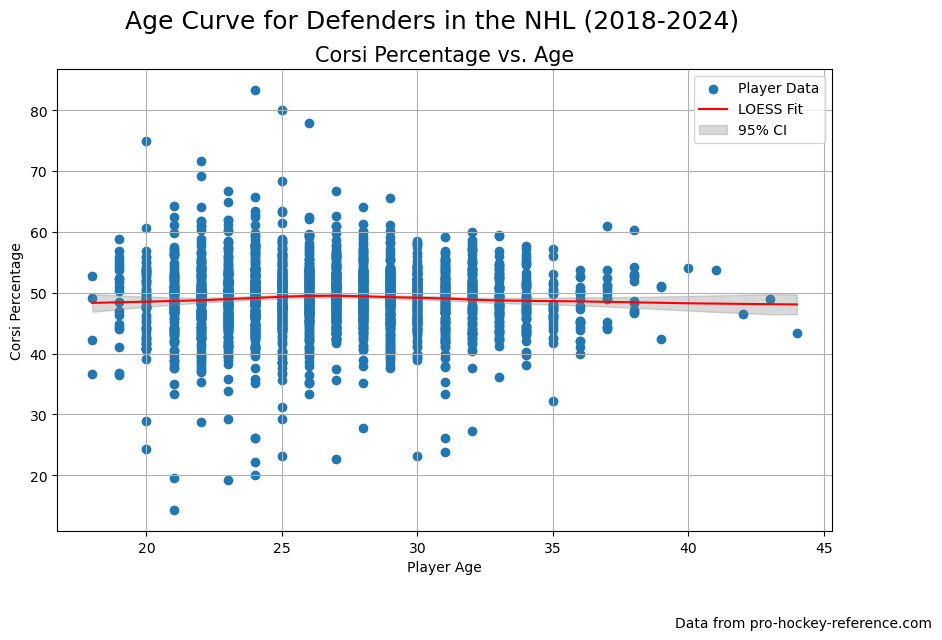

In [11]:
plt.figure(figsize=(10,6))
plt.scatter(x_d,y_d, label='Player Data')
plt.plot(xd_fit,yd_fit, color='red', label='LOESS Fit')
plt.fill_between(xd_fit, lower_band, upper_band, color='gray', alpha=0.3, label='95% CI')
plt.suptitle("Age Curve for Defenders in the NHL (2018-2024)", fontsize=18)
plt.title('Corsi Percentage vs. Age', fontsize=15)
plt.xlabel('Player Age')
plt.ylabel('Corsi Percentage')
plt.figtext(1,-0.05,"Data from pro-hockey-reference.com", ha='right')
plt.grid(True)
plt.legend();

### Normalize Y Axis

In [12]:
defender.head()

,Age,CF%,D,C,W
11,27.0,53.1,1,0,0
12,30.0,51.8,1,0,0
18,22.0,51.4,1,0,0
40,28.0,40.6,1,0,0
42,27.0,53.0,1,0,0


In [13]:
std = np.std(defender['CF%'])
mean = np.mean(defender['CF%'])
print('Mean:', mean)
print('Standard Deviation:', std)

Mean: 48.95423728813559
Standard Deviation: 5.628858860564118


In [14]:
defender['diff'] = defender['CF%'] - mean
defender.head()

,Age,CF%,D,C,W,diff
11,27.0,53.1,1,0,0,4.145763
12,30.0,51.8,1,0,0,2.845763
18,22.0,51.4,1,0,0,2.445763
40,28.0,40.6,1,0,0,-8.354237
42,27.0,53.0,1,0,0,4.045763


In [15]:
defender['Normalized CF%'] = defender['diff'] / std
defender.head()

,Age,CF%,D,C,W,diff,Normalized CF%
11,27.0,53.1,1,0,0,4.145763,0.736519
12,30.0,51.8,1,0,0,2.845763,0.505567
18,22.0,51.4,1,0,0,2.445763,0.434504
40,28.0,40.6,1,0,0,-8.354237,-1.484180
42,27.0,53.0,1,0,0,4.045763,0.718754


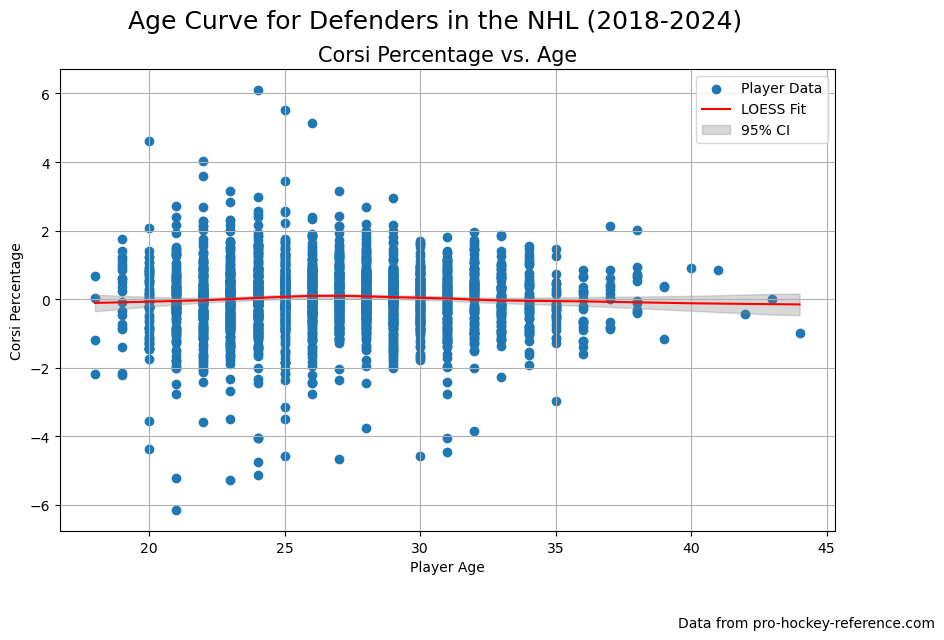

In [16]:
x_d = defender['Age'].values
y_d = defender['Normalized CF%'].values
index = np.argsort(x_d)
x_d = x_d[index]
y_d = y_d[index]

lowess = sm.nonparametric.lowess
loess_result = lowess(y_d, x_d, frac=0.5, return_sorted=True)
xd_fit = loess_result[:, 0]
yd_fit = loess_result[:, 1]

n_boot = 1000
y_boots = np.full((n_boot, len(xd_fit)), np.nan)

for i in range(n_boot):
    sample_idx = np.random.choice(len(x_d), size=len(x_d), replace=True)
    y_sample = y_d[sample_idx]
    x_sample = x_d[sample_idx]
    
    loess_boot = lowess(y_sample, x_sample, frac=0.5, return_sorted=True)
    y_b = loess_boot[:,1]
    x_b = loess_boot[:,0]

    interp = np.interp(xd_fit, x_b, y_b, left=np.nan, right=np.nan)
    y_boots[i, :] = interp

std = np.nanstd(y_boots, axis=0)
upper_band = yd_fit + 1.96 * std
lower_band = yd_fit - 1.96 * std



plt.figure(figsize=(10,6))
plt.scatter(x_d,y_d, label='Player Data')
plt.plot(xd_fit,yd_fit, color='red', label='LOESS Fit')
plt.fill_between(xd_fit, lower_band, upper_band, color='gray', alpha=0.3, label='95% CI')
plt.suptitle("Age Curve for Defenders in the NHL (2018-2024)", fontsize=18)
plt.title('Corsi Percentage vs. Age', fontsize=15)
plt.xlabel('Player Age')
plt.ylabel('Corsi Percentage')
plt.figtext(1,-0.05,"Data from pro-hockey-reference.com", ha='right')
plt.grid(True)
plt.legend();

# Defenders

In [21]:
non_goal_a = pd.read_csv('Non_goalie_advanced_data.csv')
non_goal_a = non_goal_a[['Age','GP', 'TK', 'D', 'CF% rel']]
defender_a = non_goal_a[(non_goal_a['D'] == 1)]
defender_a = defender_a.dropna()
defender_a.head(500)

,Age,GP,TK,D,CF% rel
11,27.0,2,0,1,8.4
12,30.0,9,1,1,-3.5
18,22.0,79,24,1,-3.0
40,28.0,12,3,1,-11.8
42,27.0,78,28,1,4.5
...,...,...,...,...,...
1431,37.0,10,4,1,-8.2
1435,24.0,2,1,1,-16.1
1437,26.0,68,22,1,1.8
1438,29.0,63,23,1,-1.2


In [25]:
non_goal_b = pd.read_csv('Non_Goalie_basic_data.csv')
defender_b = non_goal_b[(non_goal_b['D'] == 1)]
defender_b.head(500)

,Rk,Player,Age,Team,Pos,GP,G,A,PTS,+/-,...,FO%,BLK,HIT,TAKE,GIVE,Awards,-9999\,D,C,W
21,22,Brent Burns,33.0,SJS,D,82,16,67,83,13.0,...,0.0,105.0,90,88,118,ASGASnhl-2Hart-19Norris-2,burnsbr01\,1,0,0
38,39,Mark Giordano,35.0,CGY,D,78,17,57,74,39.0,...,NaN,144.0,58,73,65,ASnhl-1Hart-9Norris-1,giordma01\,1,0,0
51,50,Morgan Rielly,24.0,TOR,D,82,20,52,72,24.0,...,0.0,114.0,61,60,94,ASnhl-5Byng-4Norris-5,riellmo01\,1,0,0
52,51,John Carlson,29.0,WSH,D,80,13,57,70,21.0,...,NaN,164.0,54,55,87,ASGASnhl-3Norris-4,carlsjo01\,1,0,0
71,68,Keith Yandle,32.0,FLA,D,82,9,53,62,-17.0,...,NaN,76.0,47,27,110,ASGASnhl-19,yandlke01\,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1658,412,Michael Del Zotto,29.0,ANA,D,49,2,13,15,5.0,...,NaN,55.0,101,9,33,NaN,delzomi01\,1,0,0
1662,416,Radko Gudas,29.0,WSH,D,63,2,13,15,15.0,...,NaN,75.0,164,23,34,NaN,gudasra01\,1,0,0
1663,417,Henri Jokiharju,20.0,BUF,D,69,4,11,15,-6.0,...,NaN,63.0,74,7,30,NaN,jokihhe01\,1,0,0
1670,424,Marc-\'c9douard Vlasic,32.0,SJS,D,70,5,10,15,-10.0,...,NaN,97.0,37,18,40,Byng-22,vlasima01\,1,0,0


## Plus/Minus


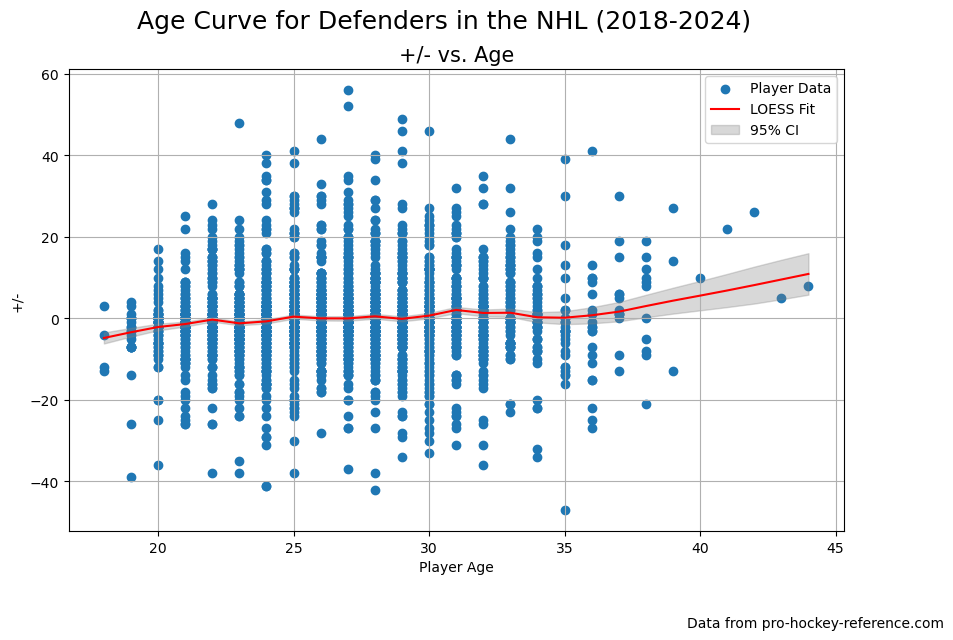

In [32]:
x_d = defender_b['Age'].values
y_d = defender_b['+/-'].values
index = np.argsort(x_d)
x_d = x_d[index]
y_d = y_d[index]

lowess = sm.nonparametric.lowess
loess_result = lowess(y_d, x_d, frac=0.15, return_sorted=True)
xd_fit = loess_result[:, 0]
yd_fit = loess_result[:, 1]

n_boot = 1000
y_boots = np.full((n_boot, len(xd_fit)), np.nan)

for i in range(n_boot):
    sample_idx = np.random.choice(len(x_d), size=len(x_d), replace=True)
    y_sample = y_d[sample_idx]
    x_sample = x_d[sample_idx]
    
    loess_boot = lowess(y_sample, x_sample, frac=0.5, return_sorted=True)
    y_b = loess_boot[:,1]
    x_b = loess_boot[:,0]

    interp = np.interp(xd_fit, x_b, y_b, left=np.nan, right=np.nan)
    y_boots[i, :] = interp

std = np.nanstd(y_boots, axis=0)
upper_band = yd_fit + 1.96 * std
lower_band = yd_fit - 1.96 * std

plt.figure(figsize=(10,6))
plt.scatter(x_d,y_d, label='Player Data')
plt.plot(xd_fit,yd_fit, color='red', label='LOESS Fit')
plt.fill_between(xd_fit, lower_band, upper_band, color='gray', alpha=0.3, label='95% CI')
plt.suptitle("Age Curve for Defenders in the NHL (2018-2024)", fontsize=18)
plt.title('+/- vs. Age', fontsize=15)
plt.xlabel('Player Age')
plt.ylabel('+/-')
plt.figtext(1,-0.05,"Data from pro-hockey-reference.com", ha='right')
plt.grid(True)
plt.legend();

## Relative Corsi Percentage
#### Relative Corsi Percentage: On Ice Corsi For % - Off Ice Corsi For %

Corsi For Percentage: Corsi For / Corsi Against

Corsi For: Number of Shot Attempts by the player's team

Corsi Against: Number of Shot Attempts against the player's team

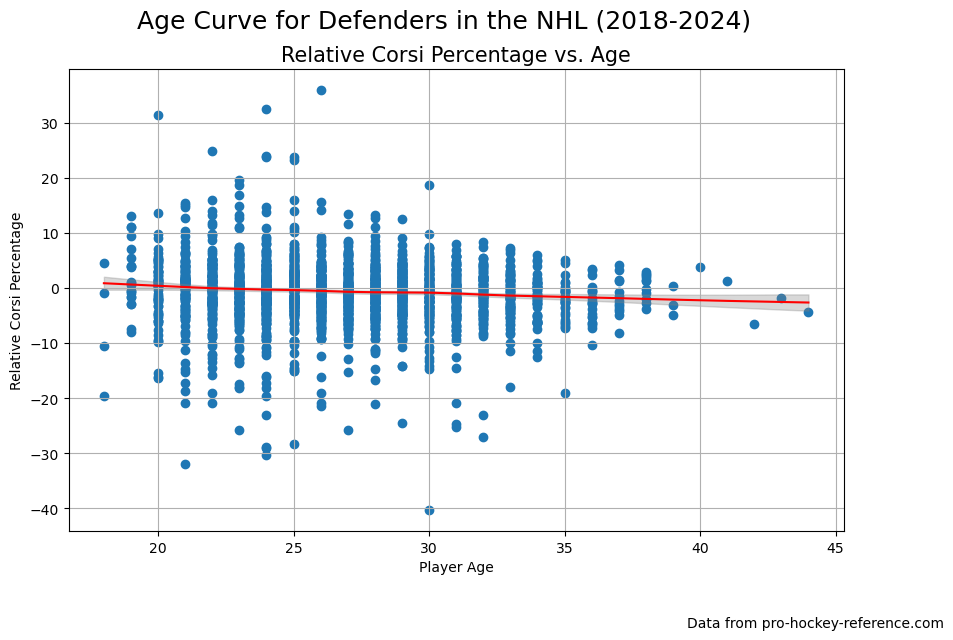

In [27]:
x_d = defender_a['Age'].values
y_d = defender_a['CF% rel'].values
index = np.argsort(x_d)
x_d = x_d[index]
y_d = y_d[index]

lowess = sm.nonparametric.lowess
loess_result = lowess(y_d, x_d, frac=0.5, return_sorted=True)
xd_fit = loess_result[:, 0]
yd_fit = loess_result[:, 1]

n_boot = 1000
y_boots = np.full((n_boot, len(xd_fit)), np.nan)

for i in range(n_boot):
    sample_idx = np.random.choice(len(x_d), size=len(x_d), replace=True)
    y_sample = y_d[sample_idx]
    x_sample = x_d[sample_idx]
    
    loess_boot = lowess(y_sample, x_sample, frac=0.5, return_sorted=True)
    y_b = loess_boot[:,1]
    x_b = loess_boot[:,0]

    interp = np.interp(xd_fit, x_b, y_b, left=np.nan, right=np.nan)
    y_boots[i, :] = interp

std = np.nanstd(y_boots, axis=0)
upper_band = yd_fit + 1.96 * std
lower_band = yd_fit - 1.96 * std

plt.figure(figsize=(10,6))
plt.scatter(x_d,y_d, label='Player Data')
plt.plot(xd_fit,yd_fit, color='red', label='LOESS Fit')
plt.fill_between(xd_fit, lower_band, upper_band, color='gray', alpha=0.3, label='95% CI')
plt.suptitle("Age Curve for Defenders in the NHL (2018-2024)", fontsize=18)
plt.title('Relative Corsi Percentage vs. Age', fontsize=15)
plt.xlabel('Player Age')
plt.ylabel('Relative Corsi Percentage')
plt.figtext(1,-0.05,"Data from pro-hockey-reference.com", ha='right')
plt.grid(True)

## Takeaways
The player takes the puck from the opposition, rather than gaining possession through opposition error

In [ ]:
x_d = defender_b['Age'].values
y_d = defender_b['TAKE'].values
index = np.argsort(x_d)
x_d = x_d[index]
y_d = y_d[index]

lowess = sm.nonparametric.lowess
loess_result = lowess(y_d, x_d, frac=0.15, return_sorted=True)
xd_fit = loess_result[:, 0]
yd_fit = loess_result[:, 1]

n_boot = 1000
y_boots = np.full((n_boot, len(xd_fit)), np.nan)

for i in range(n_boot):
    sample_idx = np.random.choice(len(x_d), size=len(x_d), replace=True)
    y_sample = y_d[sample_idx]
    x_sample = x_d[sample_idx]
    
    loess_boot = lowess(y_sample, x_sample, frac=0.5, return_sorted=True)
    y_b = loess_boot[:,1]
    x_b = loess_boot[:,0]

    interp = np.interp(xd_fit, x_b, y_b, left=np.nan, right=np.nan)
    y_boots[i, :] = interp

std = np.nanstd(y_boots, axis=0)
upper_band = yd_fit + 1.96 * std
lower_band = yd_fit - 1.96 * std

plt.figure(figsize=(10,6))
plt.scatter(x_d,y_d, label='Player Data')
plt.plot(xd_fit,yd_fit, color='red', label='LOESS Fit')
plt.fill_between(xd_fit, lower_band, upper_band, color='gray', alpha=0.3, label='95% CI')
plt.suptitle("Age Curve for Defenders in the NHL (2018-2024)", fontsize=18)
plt.title('Takeaways vs. Age', fontsize=15)
plt.xlabel('Player Age')
plt.ylabel('Takeaways')
plt.figtext(1,-0.05,"Data from pro-hockey-reference.com", ha='right')
plt.grid(True)
plt.legend();

# Wingers

In [ ]:
non_goal_a = pd.read_csv('Non_goalie_advanced_data.csv')
non_goal_a = non_goal_a[['Age','GP', 'Thru%', 'W', 'CF% rel']]
winger_a = non_goal_a[(non_goal_a['W'] == 1)]
winger_a = winger_a.dropna()
winger_a.head()

,Age,GP,Thru%,W,CF% rel
0,31.0,71,59.7,1,-2.8
2,25.0,37,48.4,1,7.4
3,25.0,22,46.6,1,-4.1
4,20.0,1,0.0,1,-1.8
7,26.0,36,55.1,1,3.5


In [31]:
non_goal_b = pd.read_csv('Non_Goalie_basic_data.csv')
winger_b = non_goal_b[(non_goal_b['W'] == 1)]
winger_b.head(500)

,Rk,Player,Age,Team,Pos,GP,G,A,PTS,+/-,...,FO%,BLK,HIT,TAKE,GIVE,Awards,-9999\,D,C,W
0,1,Nikita Kucherov,25.0,TBL,RW,82,41,87,128,24.0,...,0.0,31.0,44,58,89,ASGASnhl-1Hart-1Ross-1Pearson-1,kucheni01\,0,0,1
2,3,Patrick Kane,30.0,CHI,RW,81,44,66,110,2.0,...,20.0,18.0,21,42,54,ASGASnhl-2ASnhl-5Byng-13Hart-8,kanepa01\,0,0,1
5,6,Brad Marchand,30.0,BOS,LW,79,36,64,100,15.0,...,42.9,19.0,46,59,84,ASnhl-2Hart-5Selke-16,marchbr03\,0,0,1
6,7,Johnny Gaudreau,25.0,CGY,LW,82,36,63,99,18.0,...,33.3,12.0,12,58,124,ASGASnhl-3ASnhl-9Byng-9Hart-4,gaudrjo01\,0,0,1
10,11,Mitch Marner,21.0,TOR,RW,82,26,68,94,22.0,...,58.3,43.0,29,78,67,ASnhl-3Byng-18Selke-14,marnemi01\,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1661,415,Pierre Engvall,23.0,TOR,LW,48,8,7,15,4.0,...,39.0,10.0,29,15,23,NaN,engvapi01\,0,0,1
1666,420,Ryan Reaves,33.0,VEG,RW,71,8,7,15,-5.0,...,46.2,24.0,316,17,7,NaN,reavery01\,0,0,1
1672,426,Filip Zadina,20.0,DET,RW,28,8,7,15,-13.0,...,100.0,10.0,11,12,17,NaN,zadinfi01\,0,0,1
1681,431,Andrew Cogliano,32.0,DAL,LW,68,3,11,14,2.0,...,45.9,31.0,86,24,20,NaN,coglian01\,0,0,1


## Plus/Minus

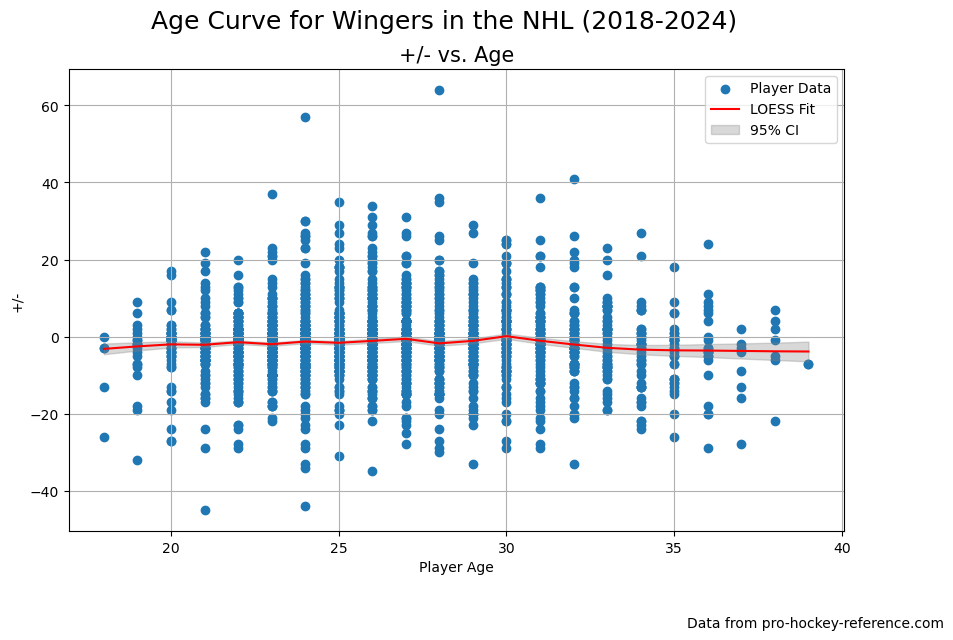

In [33]:
x_d = winger_b['Age'].values
y_d = winger_b['+/-'].values
index = np.argsort(x_d)
x_d = x_d[index]
y_d = y_d[index]

lowess = sm.nonparametric.lowess
loess_result = lowess(y_d, x_d, frac=0.15, return_sorted=True)
xd_fit = loess_result[:, 0]
yd_fit = loess_result[:, 1]

n_boot = 1000
y_boots = np.full((n_boot, len(xd_fit)), np.nan)

for i in range(n_boot):
    sample_idx = np.random.choice(len(x_d), size=len(x_d), replace=True)
    y_sample = y_d[sample_idx]
    x_sample = x_d[sample_idx]
    
    loess_boot = lowess(y_sample, x_sample, frac=0.5, return_sorted=True)
    y_b = loess_boot[:,1]
    x_b = loess_boot[:,0]

    interp = np.interp(xd_fit, x_b, y_b, left=np.nan, right=np.nan)
    y_boots[i, :] = interp

std = np.nanstd(y_boots, axis=0)
upper_band = yd_fit + 1.96 * std
lower_band = yd_fit - 1.96 * std

plt.figure(figsize=(10,6))
plt.scatter(x_d,y_d, label='Player Data')
plt.plot(xd_fit,yd_fit, color='red', label='LOESS Fit')
plt.fill_between(xd_fit, lower_band, upper_band, color='gray', alpha=0.3, label='95% CI')
plt.suptitle("Age Curve for Wingers in the NHL (2018-2024)", fontsize=18)
plt.title('+/- vs. Age', fontsize=15)
plt.xlabel('Player Age')
plt.ylabel('+/-')
plt.figtext(1,-0.05,"Data from pro-hockey-reference.com", ha='right')
plt.grid(True)
plt.legend();

## Relative Corsi Percentage

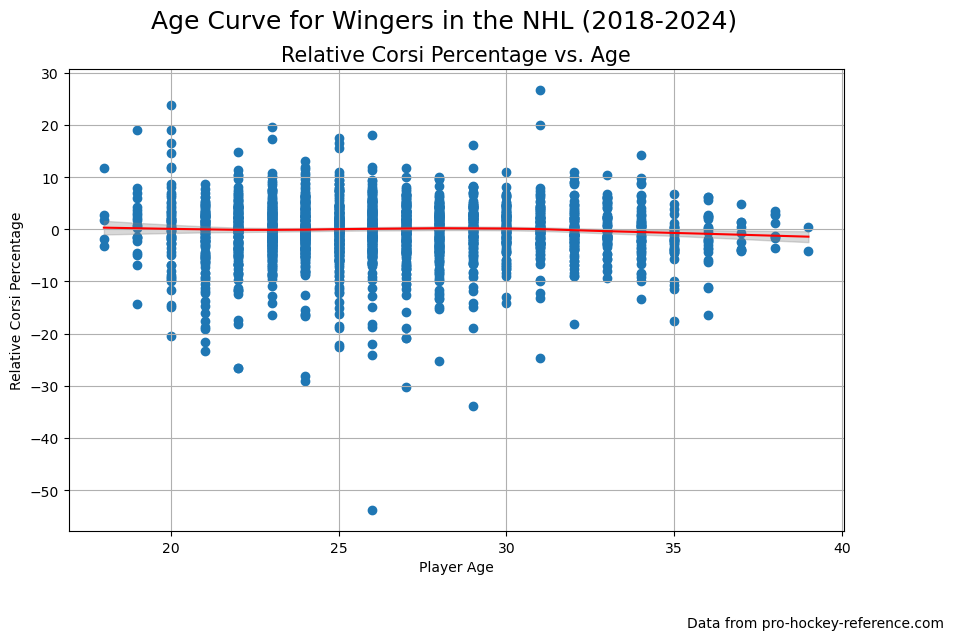

In [ ]:
x_d = winger_a['Age'].values
y_d = winger_a['CF% rel'].values
index = np.argsort(x_d)
x_d = x_d[index]
y_d = y_d[index]

lowess = sm.nonparametric.lowess
loess_result = lowess(y_d, x_d, frac=0.5, return_sorted=True)
xd_fit = loess_result[:, 0]
yd_fit = loess_result[:, 1]

n_boot = 1000
y_boots = np.full((n_boot, len(xd_fit)), np.nan)

for i in range(n_boot):
    sample_idx = np.random.choice(len(x_d), size=len(x_d), replace=True)
    y_sample = y_d[sample_idx]
    x_sample = x_d[sample_idx]
    
    loess_boot = lowess(y_sample, x_sample, frac=0.5, return_sorted=True)
    y_b = loess_boot[:,1]
    x_b = loess_boot[:,0]

    interp = np.interp(xd_fit, x_b, y_b, left=np.nan, right=np.nan)
    y_boots[i, :] = interp

std = np.nanstd(y_boots, axis=0)
upper_band = yd_fit + 1.96 * std
lower_band = yd_fit - 1.96 * std

plt.figure(figsize=(10,6))
plt.scatter(x_d,y_d, label='Player Data')
plt.plot(xd_fit,yd_fit, color='red', label='LOESS Fit')
plt.fill_between(xd_fit, lower_band, upper_band, color='gray', alpha=0.3, label='95% CI')
plt.suptitle("Age Curve for Wingers in the NHL (2018-2024)", fontsize=18)
plt.title('Relative Corsi Percentage vs. Age', fontsize=15)
plt.xlabel('Player Age')
plt.ylabel('Relative Corsi Percentage')
plt.figtext(1,-0.05,"Data from pro-hockey-reference.com", ha='right')
plt.grid(True)

## Goals + Assists

/var/folders/y4/8v71jb1d125fflwdp93ps7_c0000gn/T/ipykernel_53752/1575399254.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winger_b['Goals + Assists'] = winger_b['G'] + winger_b['A']


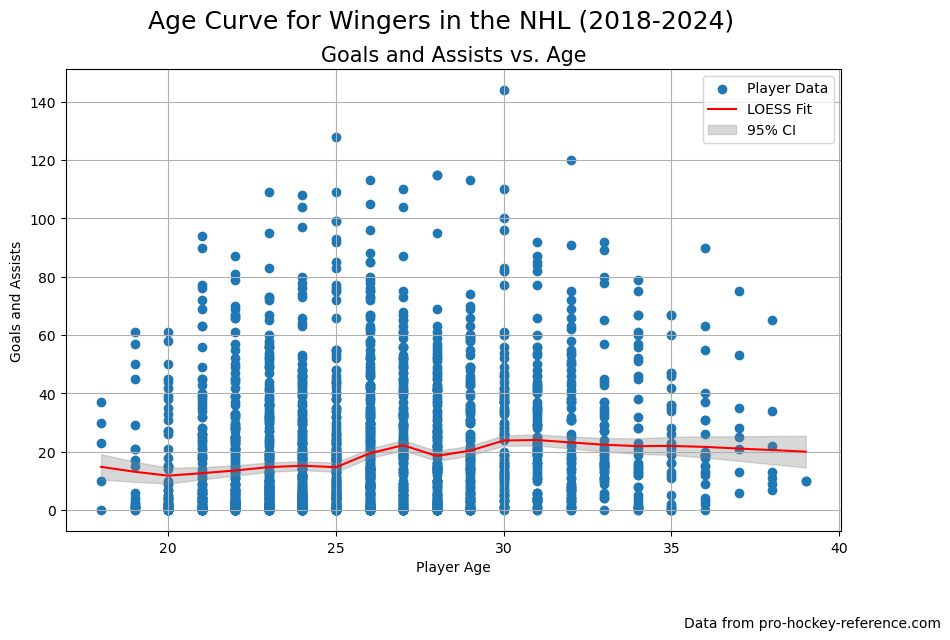

In [38]:
winger_b['Goals + Assists'] = winger_b['G'] + winger_b['A']

x_d = winger_b['Age'].values
y_d = winger_b['Goals + Assists'].values
index = np.argsort(x_d)
x_d = x_d[index]
y_d = y_d[index]

lowess = sm.nonparametric.lowess
loess_result = lowess(y_d, x_d, frac=0.15, return_sorted=True)
xd_fit = loess_result[:, 0]
yd_fit = loess_result[:, 1]

n_boot = 1000
y_boots = np.full((n_boot, len(xd_fit)), np.nan)

for i in range(n_boot):
    sample_idx = np.random.choice(len(x_d), size=len(x_d), replace=True)
    y_sample = y_d[sample_idx]
    x_sample = x_d[sample_idx]
    
    loess_boot = lowess(y_sample, x_sample, frac=0.5, return_sorted=True)
    y_b = loess_boot[:,1]
    x_b = loess_boot[:,0]

    interp = np.interp(xd_fit, x_b, y_b, left=np.nan, right=np.nan)
    y_boots[i, :] = interp

std = np.nanstd(y_boots, axis=0)
upper_band = yd_fit + 1.96 * std
lower_band = yd_fit - 1.96 * std

plt.figure(figsize=(10,6))
plt.scatter(x_d,y_d, label='Player Data')
plt.plot(xd_fit,yd_fit, color='red', label='LOESS Fit')
plt.fill_between(xd_fit, lower_band, upper_band, color='gray', alpha=0.3, label='95% CI')
plt.suptitle("Age Curve for Wingers in the NHL (2018-2024)", fontsize=18)
plt.title('Goals and Assists vs. Age', fontsize=15)
plt.xlabel('Player Age')
plt.ylabel('Goals and Assists')
plt.figtext(1,-0.05,"Data from pro-hockey-reference.com", ha='right')
plt.grid(True)
plt.legend();

# Centers

In [ ]:
non_goal_a = pd.read_csv('Non_goalie_advanced_data.csv')
non_goal_a = non_goal_a[['Age','GP', 'Thru%', 'C', 'CF% rel']]
center_a = non_goal_a[(non_goal_a['C'] == 1)]
center_a = center_a.dropna()
center_a.head()

,Age,GP,Thru%,C,CF% rel
5,27.0,72,62.3,1,-4.1
10,21.0,82,52.1,1,3.4
13,22.0,43,44.6,1,2.0
16,19.0,5,60.0,1,-8.6
17,20.0,42,65.1,1,-3.1


In [39]:
non_goal_b = pd.read_csv('Non_Goalie_basic_data.csv')
center_b = non_goal_b[(non_goal_b['C'] == 1)]
center_b.head()

,Rk,Player,Age,Team,Pos,GP,G,A,PTS,+/-,...,FO%,BLK,HIT,TAKE,GIVE,Awards,-9999\,D,C,W
1,2,Connor McDavid,22.0,EDM,C,78,41,75,116,3.0,...,46.6,30.0,39,99,89,ASGASnhl-1Byng-5Hart-3,mcdavco01\,0,1,0
3,4,Leon Draisaitl,23.0,EDM,C,82,50,55,105,2.0,...,50.5,26.0,57,71,116,ASGASnhl-4ASnhl-8,draisle01\,0,1,0
4,5,Sidney Crosby,31.0,PIT,C,79,35,65,100,18.0,...,55.4,43.0,85,54,67,ASGASnhl-2Byng-27Hart-2Selke-4,crosbsi01\,0,1,0
7,8,Nathan MacKinnon,23.0,COL,C,82,41,58,99,20.0,...,43.8,31.0,54,48,64,ASGASnhl-3Hart-6,mackina01\,0,1,0
8,9,Steven Stamkos,28.0,TBL,C,82,45,53,98,4.0,...,53.1,40.0,72,28,60,ASGASnhl-4Byng-49Hart-14,stamkst01\,0,1,0


## Relative Corsi Percentage

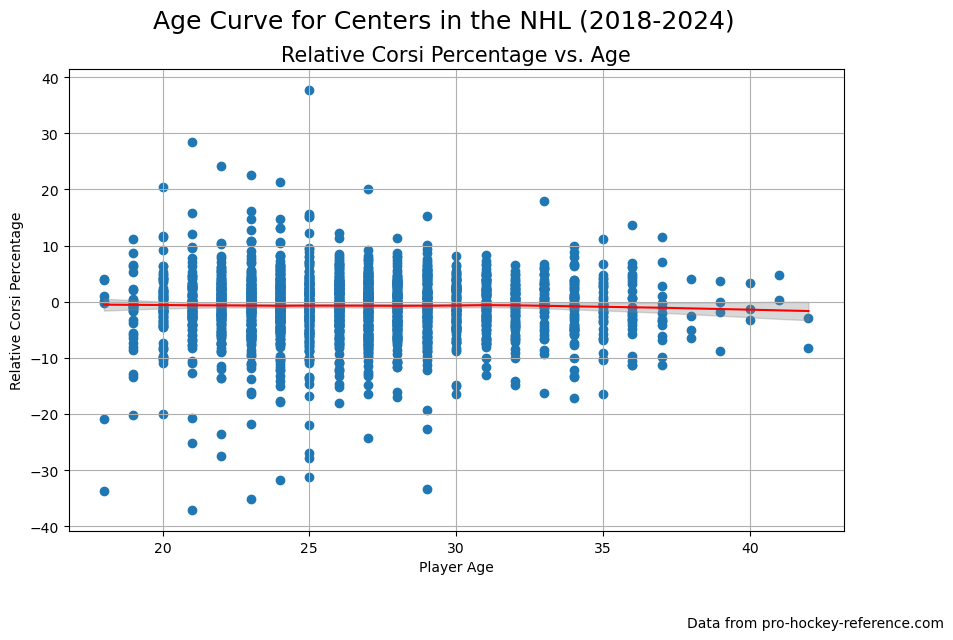

In [ ]:
x_d = center['Age'].values
y_d = center['CF% rel'].values
index = np.argsort(x_d)
x_d = x_d[index]
y_d = y_d[index]

lowess = sm.nonparametric.lowess
loess_result = lowess(y_d, x_d, frac=0.5, return_sorted=True)
xd_fit = loess_result[:, 0]
yd_fit = loess_result[:, 1]

n_boot = 1000
y_boots = np.full((n_boot, len(xd_fit)), np.nan)

for i in range(n_boot):
    sample_idx = np.random.choice(len(x_d), size=len(x_d), replace=True)
    y_sample = y_d[sample_idx]
    x_sample = x_d[sample_idx]
    
    loess_boot = lowess(y_sample, x_sample, frac=0.5, return_sorted=True)
    y_b = loess_boot[:,1]
    x_b = loess_boot[:,0]

    interp = np.interp(xd_fit, x_b, y_b, left=np.nan, right=np.nan)
    y_boots[i, :] = interp

std = np.nanstd(y_boots, axis=0)
upper_band = yd_fit + 1.96 * std
lower_band = yd_fit - 1.96 * std

plt.figure(figsize=(10,6))
plt.scatter(x_d,y_d, label='Player Data')
plt.plot(xd_fit,yd_fit, color='red', label='LOESS Fit')
plt.fill_between(xd_fit, lower_band, upper_band, color='gray', alpha=0.3, label='95% CI')
plt.suptitle("Age Curve for Centers in the NHL (2018-2024)", fontsize=18)
plt.title('Relative Corsi Percentage vs. Age', fontsize=15)
plt.xlabel('Player Age')
plt.ylabel('Relative Corsi Percentage')
plt.figtext(1,-0.05,"Data from pro-hockey-reference.com", ha='right')
plt.grid(True)

## Plus/Minus

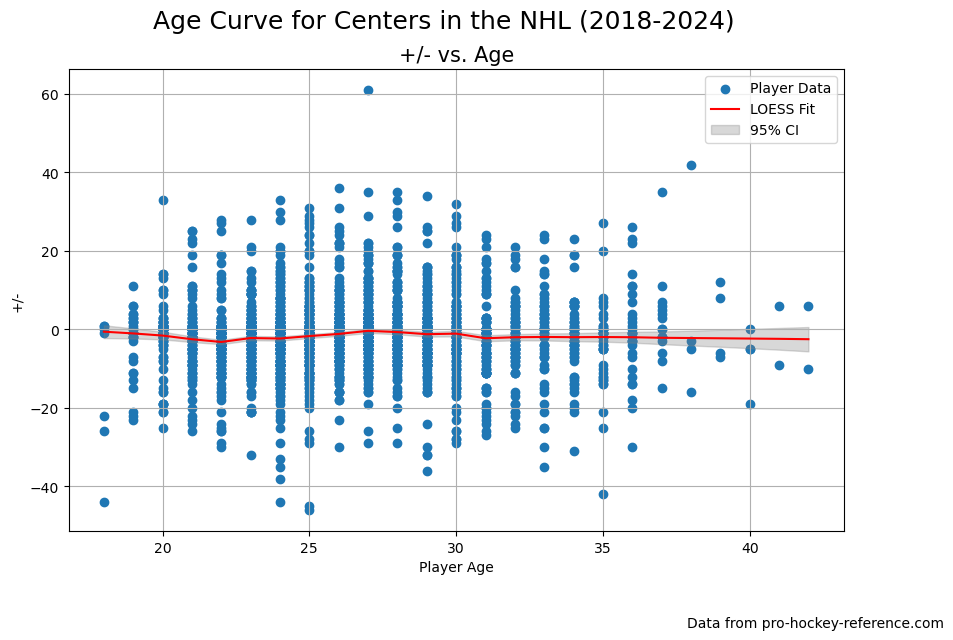

In [40]:
x_d = center_b['Age'].values
y_d = center_b['+/-'].values
index = np.argsort(x_d)
x_d = x_d[index]
y_d = y_d[index]

lowess = sm.nonparametric.lowess
loess_result = lowess(y_d, x_d, frac=0.15, return_sorted=True)
xd_fit = loess_result[:, 0]
yd_fit = loess_result[:, 1]

n_boot = 1000
y_boots = np.full((n_boot, len(xd_fit)), np.nan)

for i in range(n_boot):
    sample_idx = np.random.choice(len(x_d), size=len(x_d), replace=True)
    y_sample = y_d[sample_idx]
    x_sample = x_d[sample_idx]
    
    loess_boot = lowess(y_sample, x_sample, frac=0.5, return_sorted=True)
    y_b = loess_boot[:,1]
    x_b = loess_boot[:,0]

    interp = np.interp(xd_fit, x_b, y_b, left=np.nan, right=np.nan)
    y_boots[i, :] = interp

std = np.nanstd(y_boots, axis=0)
upper_band = yd_fit + 1.96 * std
lower_band = yd_fit - 1.96 * std

plt.figure(figsize=(10,6))
plt.scatter(x_d,y_d, label='Player Data')
plt.plot(xd_fit,yd_fit, color='red', label='LOESS Fit')
plt.fill_between(xd_fit, lower_band, upper_band, color='gray', alpha=0.3, label='95% CI')
plt.suptitle("Age Curve for Centers in the NHL (2018-2024)", fontsize=18)
plt.title('+/- vs. Age', fontsize=15)
plt.xlabel('Player Age')
plt.ylabel('+/-')
plt.figtext(1,-0.05,"Data from pro-hockey-reference.com", ha='right')
plt.grid(True)
plt.legend();

In [ ]:
## Goals and Assists

/var/folders/y4/8v71jb1d125fflwdp93ps7_c0000gn/T/ipykernel_53752/1156087223.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  center_b['Goals + Assists'] = center_b['G'] + center_b['A']


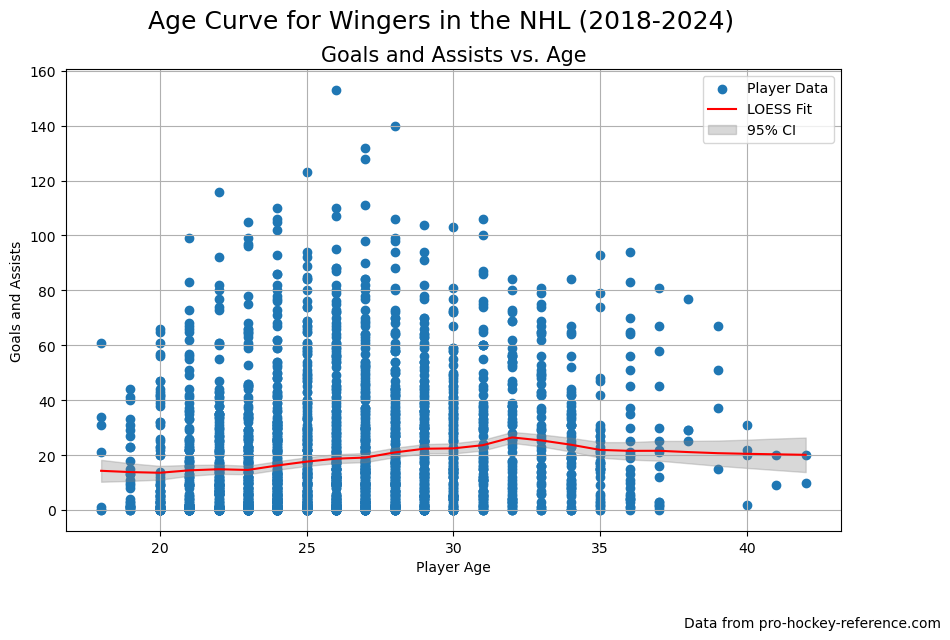

In [42]:
center_b['Goals + Assists'] = center_b['G'] + center_b['A']

x_d = center_b['Age'].values
y_d = center_b['Goals + Assists'].values
index = np.argsort(x_d)
x_d = x_d[index]
y_d = y_d[index]

lowess = sm.nonparametric.lowess
loess_result = lowess(y_d, x_d, frac=0.15, return_sorted=True)
xd_fit = loess_result[:, 0]
yd_fit = loess_result[:, 1]

n_boot = 1000
y_boots = np.full((n_boot, len(xd_fit)), np.nan)

for i in range(n_boot):
    sample_idx = np.random.choice(len(x_d), size=len(x_d), replace=True)
    y_sample = y_d[sample_idx]
    x_sample = x_d[sample_idx]
    
    loess_boot = lowess(y_sample, x_sample, frac=0.5, return_sorted=True)
    y_b = loess_boot[:,1]
    x_b = loess_boot[:,0]

    interp = np.interp(xd_fit, x_b, y_b, left=np.nan, right=np.nan)
    y_boots[i, :] = interp

std = np.nanstd(y_boots, axis=0)
upper_band = yd_fit + 1.96 * std
lower_band = yd_fit - 1.96 * std

plt.figure(figsize=(10,6))
plt.scatter(x_d,y_d, label='Player Data')
plt.plot(xd_fit,yd_fit, color='red', label='LOESS Fit')
plt.fill_between(xd_fit, lower_band, upper_band, color='gray', alpha=0.3, label='95% CI')
plt.suptitle("Age Curve for Wingers in the NHL (2018-2024)", fontsize=18)
plt.title('Goals and Assists vs. Age', fontsize=15)
plt.xlabel('Player Age')
plt.ylabel('Goals and Assists')
plt.figtext(1,-0.05,"Data from pro-hockey-reference.com", ha='right')
plt.grid(True)
plt.legend();